# Spatial wavefield gradient-based seismic wavefield separation

## 01 P/S separation of field land data

This notebook shows the spatial wavefield gradient-based technique to a multicomponent land seismic data set acquired in northern Switzerland to characterize the geometry and infill of a Quaternary valley (Schmelzbach et al. 2014; Sollberger et al. 2014). Near-surface studies benefit from the enhanced resolution and improved lithological characterization achieved by S-wave and converted-wave exploration. We therefore test our P/S separation filters to suppress P-waves on the horizontal particle velocity component recordings for S-wave imaging.

The survey consisted of a 250 m long 2D line of 3C geophones spaced at 1.5 m intervals. Seismic data were generated by striking a prismatic wedge (3C vector source, Schmelzbach et al. 2016) with a sledgehammer at 3 m intervals along the recording line.

The P/S separation of the recorded horizontal particle velocity was carried out using the equation below (see Van Renterghem et al. (2018) for details):

$$
v_x^{S^U} \approx \frac{\beta}{i\omega}(\nabla \times v^U)_y \approx \frac{1}{2}(v_x - \frac{1}{i\omega} 2\beta \frac{\partial v_z}{\partial x})
$$

The horizontal spatial wavefield gradients of the vertical particle velocities were calculated by finite-differencing the recordings from three neighbouring stations and centring the estimate at the middle receiver. The S-wave velocity was obtained from the traveltime tomography results in Schmelzbach et al. (2014) and is about 300 m/s at the surface.

In [1]:
# import libraries 
# ----------------
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# check .mat file 
# ---------------
from scipy.io import whosmat
whosmat('Neuhausen_data.mat') # to list variables inside mat file

[('dt', (1, 1), 'double'),
 ('tmax', (1, 1), 'double'),
 ('nt', (1, 1), 'double'),
 ('timevector', (1, 4000), 'double'),
 ('shot', (1, 1), 'double'),
 ('coord_rec', (88, 3), 'double'),
 ('coord_src', (1, 3), 'double'),
 ('distance_rec', (1, 87), 'double'),
 ('distance_src_rec', (1, 88), 'double'),
 ('vx', (4000, 88), 'double'),
 ('vz', (4000, 88), 'double')]

In [3]:
# load .mat file 
# --------------
from scipy.io import loadmat
mat = loadmat('Neuhausen_data.mat')  # to load mat file
# convert them to numpy array
vx = mat['vx']
vz = mat['vz']
dt = mat['dt'][0,0]
nt = mat['nt'][0,0]
tmax = mat['tmax'][0,0]
shot = mat['shot'][0,0]
coord_rec  = mat['coord_rec']
coord_src  = mat['coord_src']
timevector = mat['timevector'][0,:]
distance_rec     = mat['distance_rec'][0,:]
distance_src_rec = mat['distance_src_rec'][0,:]
mat = 0

In [4]:
# initialize parameters 
# ---------------------
alpha = 600  # P-wave velocity
beta = 300   # S-wave velocity

In [5]:
# calculate wavefield gradients 
# -----------------------------
from fd_weights import *

# allocate zero gradients
gradx_vx = np.zeros((vx.shape[0],vx.shape[1]))
gradx_vz = np.zeros((vz.shape[0],vz.shape[1]))

# calculate spatial wavefield gradients 
for n in range(1,(vx.shape[1]-1)):
    # FD coefficents according to Fornberg (1988)
    c = fd_weights(0, [-distance_rec[n-1], distance_rec[n] - distance_rec[n], distance_rec[n]], 2)
    # horizontal gradient of vx
    gradx_vx[:,n] = ((c[0]*vx[:,n-1]) + (c[1]*vx[:,n]) + (c[2]*vx[:,n+1])) 
    # horizontal gradient of vz
    gradx_vz[:,n] = ((c[0]*vz[:,n-1]) + (c[1]*vz[:,n]) + (c[2]*vz[:,n+1])) 

# P/S separation 
# --------------
# upgoing P-wave on vz
vz_P_up = (1/2.) * (vz + ((beta*((2*beta)/alpha)) * (gradx_vx.cumsum(axis=0)*dt))) 
# upgoing S-wave on vx
vx_S_up = (1/2.) * (vx - ((2*beta) * (gradx_vz.cumsum(axis=0)*dt)))

In [6]:
# data scaling
# ------------
vx_scal = np.std(vx, axis=0) # column-wise std
vx_scal = np.matlib.repmat(vx_scal, vx.shape[0], 1)
vx_new = (vx / vx_scal)
vx_S_up_new = (vx_S_up / vx_scal)

<IPython.core.display.Javascript object>


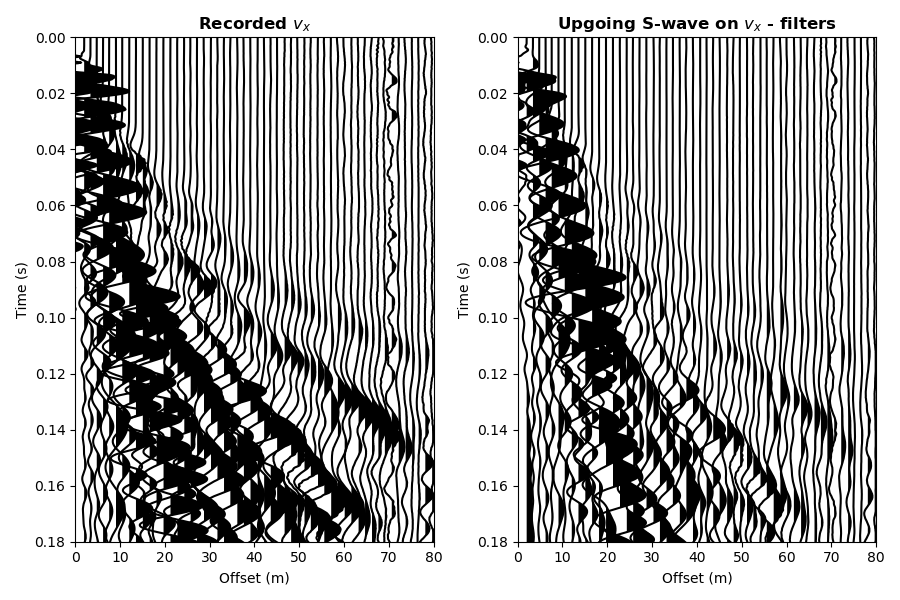

In [7]:
# plotting configuration 
# ----------------------
from wiggle import *
plt.figure(figsize=(9, 6))

# recorded vx
plt.subplot(1,2,1)
wiggle(vx_new, timevector, distance_src_rec, color='k')
plt.xlabel('Offset (m)')
plt.ylabel('Time (s)')
plt.title('Recorded $v_x$',fontweight="bold")
plt.xlim(0,80)
plt.ylim(0.18,0.0)

# P/S separated upgoing vx
plt.subplot(1,2,2)
wiggle(vx_S_up_new, timevector, distance_src_rec, color='k')
plt.xlabel('Offset (m)')
plt.ylabel('Time (s)')
plt.title('Upgoing S-wave on $v_x$ - filters',fontweight="bold")
plt.xlim(0,80)
plt.ylim(0.18,0.0)

# show result on screen
plt.tight_layout()
plt.show()

The figures above shows that our spatial wavefield gradient-based P/S separation filters effectively suppress the undesired P-wave arrival to obtain a horizontal component recording that only contains S-waves.